In [ ]:
pip install transformers datasets rouge_score matplotlib seaborn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=60ef433a36ba10d2fe6abb459932ee35ed24e5112991750dfd0aa234e06b6f64
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling re

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import BartTokenizer, BartForConditionalGeneration
from rouge_score import rouge_scorer


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset = load_dataset("cnn_dailymail", "3.0.0", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [ ]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn').to(device)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [ ]:
def generate_summary(text):
    inputs = tokenizer(text, max_length=1024, return_tensors="pt", truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to GPU
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, max_length=150, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [8]:
sampled_dataset = dataset.select(range(100))
summaries = [generate_summary(article['article']) for article in sampled_dataset]

In [15]:
# Print original texts and generated summaries
for i, article in enumerate(sampled_dataset):
    original_text = article['article']
    summary = summaries[i]
    print(f"Article {i+1} Original Text:")
    print(original_text)
    print("\nGenerated Summary:")
    print(summary)
    print("="*80)

Article 1 Original Text:
(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, speaking at

In [13]:
# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores for all articles
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for pred, ref in zip(summaries, sampled_dataset):
    rouge_scores = scorer.score(pred, ref['highlights'])
    rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
    rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
    rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

# Calculate average ROUGE scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

# Print the summary of ROUGE scores
print("Summary of ROUGE Scores:")
print(f"  Average ROUGE-1: {avg_rouge1:.4f}")
print(f"  Average ROUGE-2: {avg_rouge2:.4f}")
print(f"  Average ROUGE-L: {avg_rougeL:.4f}")


Summary of ROUGE Scores:
  Average ROUGE-1: 0.3501
  Average ROUGE-2: 0.1527
  Average ROUGE-L: 0.2633


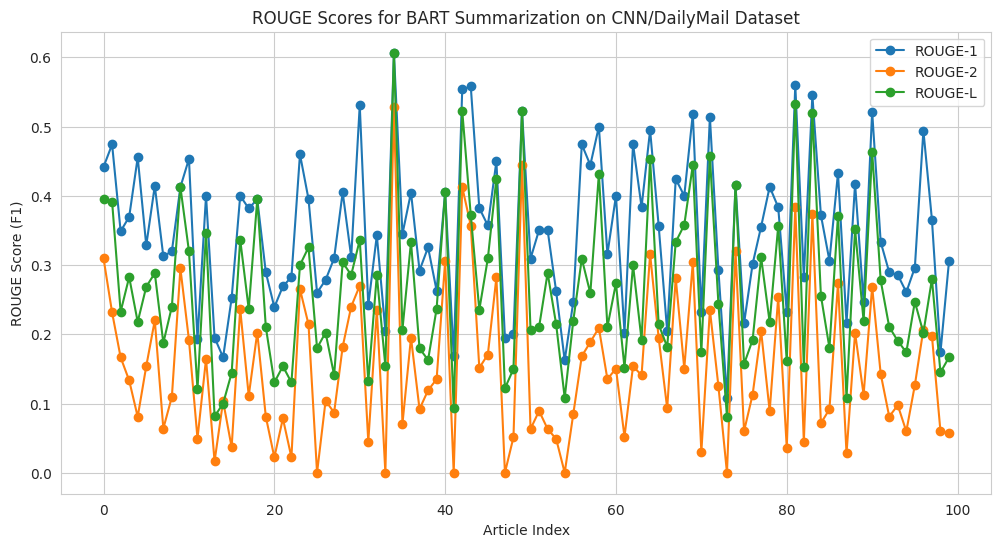

In [14]:
# Plot the ROUGE scores
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

plt.plot(rouge1_scores, label='ROUGE-1', marker='o')
plt.plot(rouge2_scores, label='ROUGE-2', marker='o')
plt.plot(rougeL_scores, label='ROUGE-L', marker='o')

plt.title('ROUGE Scores for BART Summarization on CNN/DailyMail Dataset')
plt.xlabel('Article Index')
plt.ylabel('ROUGE Score (F1)')
plt.legend()
plt.show()

Generated Summary:
The fox is quick and the dog is lazy, contrasting their behaviors in this short, yet vivid sentence. This classic sentence contains every letter of the alphabet at least once, making it a popular example of a pangram. The quick brown fox jumps over the lazy dog.

ROUGE Scores:
  ROUGE-1: 0.6500
  ROUGE-2: 0.3846
  ROUGE-L: 0.4000


<ipython-input-17-5063dbc9281c>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette='viridis')


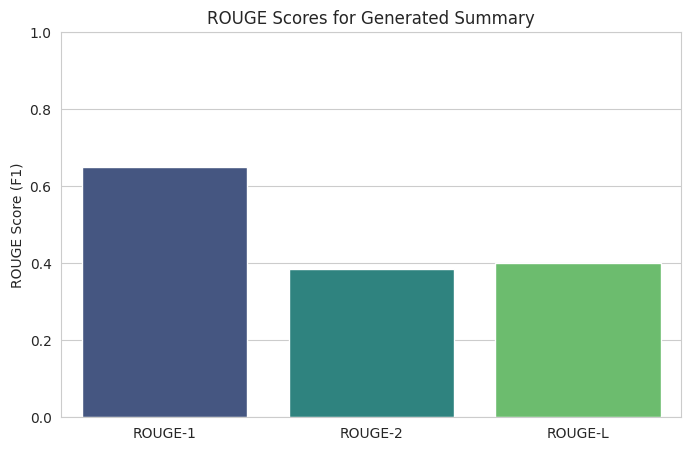

In [17]:
# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BART tokenizer and model, then move the model to the GPU
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn').to(device)

# Function to generate summaries using BART
def generate_summary(text):
    inputs = tokenizer(text, max_length=1024, return_tensors="pt", truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to GPU
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, max_length=150, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

def evaluate_summary(sample_text, reference_summary):
    """
    Generate a summary for the given sample text and evaluate it using ROUGE scores.

    Parameters:
    sample_text (str): The text to be summarized.
    reference_summary (str): The reference summary for ROUGE evaluation.

    Returns:
    dict: The ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L).
    """
    # Generate summary
    generated_summary = generate_summary(sample_text)

    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Compute ROUGE scores
    scores = scorer.score(generated_summary, reference_summary)

    # Print results
    print(f"Generated Summary:\n{generated_summary}")
    print("\nROUGE Scores:")
    print(f"  ROUGE-1: {scores['rouge1'].fmeasure:.4f}")
    print(f"  ROUGE-2: {scores['rouge2'].fmeasure:.4f}")
    print(f"  ROUGE-L: {scores['rougeL'].fmeasure:.4f}")

    # Plot the results
    plot_rouge_scores(scores)

def plot_rouge_scores(scores):
    """
    Plot ROUGE scores.

    Parameters:
    scores (dict): The ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L).
    """
    labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
    values = [scores['rouge1'].fmeasure, scores['rouge2'].fmeasure, scores['rougeL'].fmeasure]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=labels, y=values, palette='viridis')
    plt.title('ROUGE Scores for Generated Summary')
    plt.ylabel('ROUGE Score (F1)')
    plt.ylim(0, 1)  # ROUGE scores range from 0 to 1
    plt.show()

# Example usage
sample_text = """
    The quick brown fox jumps over the lazy dog. This classic sentence contains every letter of the alphabet at least once,
    making it a popular example of a pangram. The fox is quick and the dog is lazy, contrasting their behaviors in this
    short, yet vivid sentence.
"""

reference_summary = """
    The quick brown fox jumps over the lazy dog. This sentence is a well-known pangram that uses every letter of the alphabet,
    showcasing the contrasting characteristics of the fox and the dog.
"""

# Evaluate and plot ROUGE scores for the sample text
evaluate_summary(sample_text, reference_summary)
